<a href="https://colab.research.google.com/github/TanguyLaucournet/Sentiment-Analysis-to-predict-Stock/blob/main/SnTweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

5) Webscrapping Twitter banquier centraux (U.E ou US) pour prédiction tendance up ou down du SX5E (si Europe) ou NYSE (si US)
- L'idée est de partir des twitts #BCE ou #fed par exemple ou les twit des banquiers centraux (Christine Lagarde, François Villeroy De Gallhau par ex...) et d'essayer d'estimer via ces twit quel sera la tendance (up ou down) du SX5E dans le futur.
- Par exemple vous pouvez prendre le cours du SX5E et des différents actions qui le constituent + ajouter le sentiment dégagé par les twit de Christine Lagarde comme variable explicative pour prédire si au mois n+1 le cours du sx5e va augmenter ou baisser.
- Vous êtes libres de prendre la profondeur que vous jugerez pertinentes (profondeur en retwitt et en nombre de jours avant le mois n+1

In [5]:
!pip install snscrape
!pip install langdetect
!pip install nltk

     |████████████████████████████████| 983kB 5.7MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=15db9719d447156bfba677292fb79f70d72bcaabfee7715007249ad4adb824b9
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [6]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import pandas_datareader as web
import numpy as np
from langdetect import detect
import re
import matplotlib.pyplot as plt
import nltk

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [8]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
tweets_list= []
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('SX5E since:2015-06-01 until:2021-01-01').get_items()):
  if i>5000:
    break
  tweets_list.append([tweet.date, tweet.content, tweet.username])
tweets_df = pd.DataFrame(tweets_list, columns=['Date', 'Text', 'Username'])
tweets_df['Date'] = pd.to_datetime(tweets_df['Date']).dt.date

In [ ]:

def deleteNonEnglishTweet(text):
  lang = detect(text)
  if lang != 'en' or "SX5E" not in text:
    text=''
  
  else:
    return (text)

tweets_df['Text'] = tweets_df['Text'].apply(lambda x: deleteNonEnglishTweet(x))
# replace epmty string with np.nan to drop them easily
tweets_df['Text'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['Text'], inplace=True)

In [ ]:
#Drop tweets from IC_Markets wich is a bot
tweets_df['Username'].replace('IC_Markets', np.nan, inplace=True)
tweets_df.dropna(subset=['Username'], inplace=True)

In [ ]:
tweets_df['Text'] = tweets_df['Text'].apply(lambda x: x.replace('#SX5E', 'SX5E'))

In [ ]:

#Regex to delete some content (link,user,hashtag)

web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
sx5e = re.compile(r"(?i)@SX5E(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")
hashtag = re.compile(r"(?i)#[A-Za-z0-9]+")

# we then use the sub method to replace anything matching
tweets_df['Text'] = tweets_df['Text'].apply(lambda x : web_address.sub('', x))
tweets_df['Text'] = tweets_df['Text'].apply(lambda x : user.sub('', x))
tweets_df['Text'] = tweets_df['Text'].apply(lambda x : sx5e.sub('SX5E', x))
tweets_df['Text'] = tweets_df['Text'].apply(lambda x : hashtag.sub('', x))






In [ ]:
vader = SentimentIntensityAnalyzer()
tweets_df['compound'] = tweets_df['Text'].apply(lambda x: vader.polarity_scores(x)['compound'])
#adding sentiments to my df with vader

I wanted to add sentiments from news articles but for SX5E I only found french articles wich can't be analyse by vader_lexicon

In [23]:
from bs4 import BeautifulSoup 
from requests import get

titles = []
dates = []
url = "https://www.boursorama.com/bourse/indices/cours/actualites/2cSX5E/page-"

for i in range(0,15):
  url+= str(i)
  response = get(url)
  html_soup = BeautifulSoup(response.text,'html.parser')
  title_containers = html_soup.find_all('div', class_="c-list-details-news__title")
  date_containers = html_soup.find_all('span', class_="c-source__time")
  for j in range(0,len(title_containers)):
    titles.append(title_containers[j].a.get_text())
  for h in range(0,len(date_containers)):
      if h%2==0:
        dates.append(date_containers[h].string)


data  = pd.DataFrame({
        'titles': titles,
        'dates': dates,
})

data['compound'] = data['titles'].apply(lambda x: vader.polarity_scores(x)['compound'])

In [24]:
data

,titles,dates,compound
0,POINT MARCHÉS-Hausse prudente en vue à Wall St...,05.01.2021,0.00
1,"POINT MARCHÉS-L'Europe en ordre dispersé, Lond...",05.01.2021,0.00
2,"POINT MARCHÉS-Prudence en vue en Europe, incer...",05.01.2021,0.00
3,POINT MARCHÉS-Les actions réduisent leurs gain...,04.01.2021,0.34
4,POINT MARCHÉS-Les vaccins assurent aux actions...,04.01.2021,0.00
5,POINT MARCHÉS-L'année démarre bien pour les Bo...,04.01.2021,0.00
6,POINT MARCHÉS-Vers une ouverture en hausse pou...,04.01.2021,0.00
7,POINT MARCHÉS-L'Europe finit en baisse une ann...,31.12.2020,0.00
8,POINT MARCHÉS-Repli dans le calme en Europe av...,31.12.2020,0.00
9,POINT MARCHÉS-Repli en vue pour la dernière sé...,31.12.2020,0.00


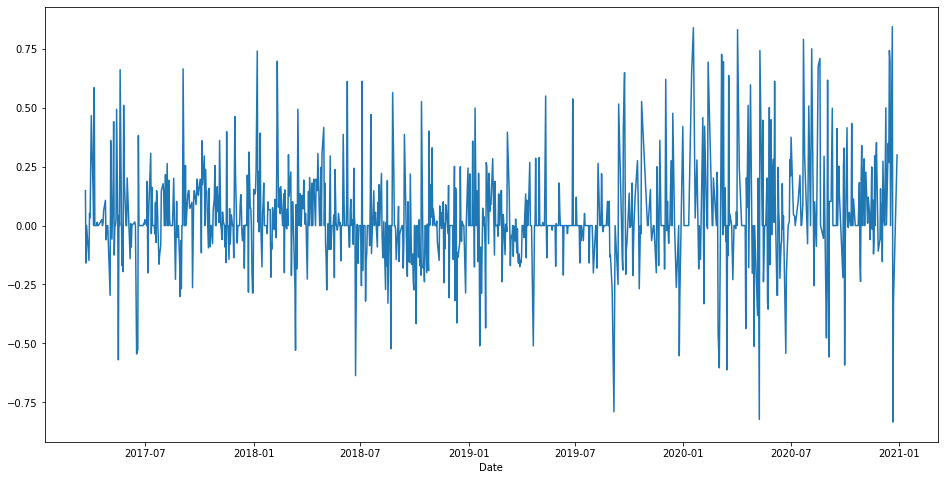

In [ ]:
# graph for sentiments
mean_df = pd.DataFrame(columns=['Date', 'sentiment'])
plt.figure(figsize=(16,8))
mean_df = tweets_df.groupby(['Date']).mean()
mean_df = mean_df.xs('compound', axis="columns")
mean_df.plot()
plt.show()

In [ ]:
#get Stoxx 50 price
price_df = web.DataReader('^STOXX50E', data_source='yahoo', start='2015-06-01', end='2021-01-01')

Text(0.5, 0, 'Price')

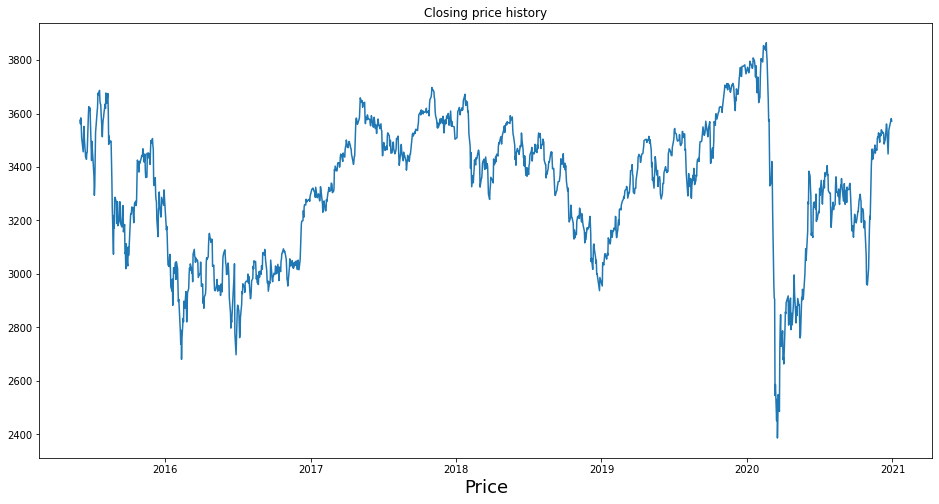

In [ ]:
# graph price
plt.figure(figsize=(16,8))
plt.title('Closing price history')
plt.plot(price_df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.xlabel('Price', fontsize = 18)

In [ ]:

#add sentiment to main df
price_df['sentiment']=mean_df
price_df['sentiment'].fillna(0, inplace = True)
#add label to main df
label=[]
for i in range(len(price_df.index)):
  if price_df['Close'][i]>price_df['Open'][i]:
    label.append(1)
  else:
    label.append(0)
price_df['label'] = label

In [ ]:
# column to keep
keep_col = ['Open','High','Low','Volume','sentiment','label']
df = price_df[keep_col]

In [ ]:
#Create feature data set
X = df
X = np.array(X.drop(['label'],1))

#Create target data set
y = np.array(df['label'])

In [ ]:
#Split data 80% training 20% test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0 )

In [ ]:
#Create the model 
model = LinearDiscriminantAnalysis().fit(x_train,y_train)

In [ ]:
# Show prediction
predictions = model.predict(x_test)
predictions

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1])

In [ ]:
y_test

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [ ]:
# Show metrics
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       142
           1       0.83      0.80      0.81       140

    accuracy                           0.82       282
   macro avg       0.82      0.82      0.82       282
weighted avg       0.82      0.82      0.82       282

